LIBRERIAS

In [64]:
import cv2
import numpy as np
import pandas as pd
import os
import argparse
from matplotlib import pyplot as plt
import matplotlib.image as img
import seaborn as sns

from sklearn.preprocessing import normalize                           
from sklearn.cluster import KMeans, DBSCAN
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors
from skimage import data, segmentation, color
from skimage.future import graph
from sklearn import cluster
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import label_binarize
from sklearn.cluster import spectral_clustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier

from numpy import linspace

from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage
import seaborn as sns
from cv2 import MORPH_ELLIPSE

#from kneed import KneeLocator
import seaborn
from skimage.feature import graycomatrix, graycoprops
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Lambda, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
import skimage.morphology
from featurewiz import featurewiz

In [22]:
# funciones
from Codigos_F.funciones import get_min_max_feret_from_mask
from Codigos_F.funciones import selContorno,selRegion,matrizConfusion,MedidasMC,similitud

Cargar el modelo entrenamiento UNET


In [16]:
model1 = load_model('PesosModelo/unetNucleo4.h5')
model1.load_weights('PesosModelo/unetNucleoPesos4.h5')

In [7]:
model2 = load_model('PesosModelo/unetCito2.h5')
model2.load_weights('PesosModelo/unetCitoPesos2.h5')

ValueError: bad marshal data (unknown type code)

PROCESAMIENTO IMAGEN INDIVIDUAL

1/1 [==============================] - 1s 813ms/step
He encontrado 1 posibles nucleos


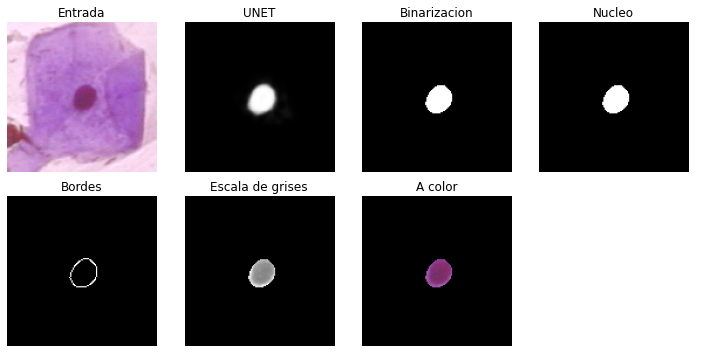

In [17]:
# RUTA DE LA IMAGEN
dirCarpeta = 'DatasetNormalizado/1_normal_superficiel/normalSup2.jpg'
#dirCarpeta = 'DatasetNormalizado/2_normal_intermediate/normalInter20.jpg'
#dirCarpeta = 'DatasetNormalizado/3_normal_columnar/normalCol88.jpg'
#dirCarpeta = 'DatasetNormalizado/4_light_dysplastic/anormalMild50.jpg'
#dirCarpeta = 'DatasetNormalizado/5_moderate_dysplastic/anormalMod63.jpg'
#dirCarpeta = 'DatasetNormalizado/6_severe_dysplastic/anormalSevere182.jpg'
#dirCarpeta = 'DatasetNormalizado/7_carcinoma_in_situ/anormalCIS144.jpg'
#dirCarpeta = 'ADICIONALES/035.bmp'

# PREPROCESAMIENTO
# BGR
imagen = cv2.imread(dirCarpeta)[:,:,:3]
#imagen = cv2.cvtColor(imagen,cv2.COLOR_BGR2RGB)
imagen = cv2.resize(imagen,dsize=(128,128))
imagen2 = imagen.copy()
imagenT = np.array([imagen2,imagen2])

case= 1
if case == 1:
    segmentacion = model1.predict(imagenT)
elif case == 2:
    segmentacion = model2.predict(imagenT)


imgIn = imagen.copy()
seg = segmentacion[0].reshape(128,128)
seg = Lambda(lambda x: x*255)(seg)
seg = np.asarray(seg,dtype=np.uint8)
# Aplicar filtro de mediana con kernel de 5x5
gauss = cv2.medianBlur(seg,11)
#binarizacion por el metodo de otsu
ret3, binarizar = cv2.threshold(gauss,10,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#operacion morofologica
ele  = cv2.getStructuringElement(MORPH_ELLIPSE,ksize=(3,3))
binarizar = cv2.erode(binarizar,ele,iterations=2)
binarizar = cv2.dilate(binarizar,ele,iterations=2)

 # Buscamos los contornos
(contornos,_) = cv2.findContours(binarizar.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print("He encontrado {} posibles nucleos".format(len(contornos)))
contorno,cx,cy = selContorno(contornos,binarizar)
cv2.drawContours(imgIn,contornos,-1,(255,255,0), 2)
#seleccionador de regiones
area = cv2.contourArea(contornos[contorno])
_, label, _,centroids = cv2.connectedComponentsWithStats(binarizar)
imagenReg = selRegion(label,area)
imagenReg[imagenReg > 200] = 255
imagenReg[imagenReg != 255] = 0
# deteccion de bordes
bordes = cv2.Canny(imagenReg, 10, 150)

#imagen en gris y color
imgColor = imagen.copy()
gris = cv2.cvtColor(imagen,cv2.COLOR_BGR2GRAY)
for fila in range (gris.shape[0]):
    for columna in range (gris.shape[1]):
        if imagenReg[fila][columna] == 0:
            gris[fila][columna] = 0
            imgColor[fila][columna] = 0
        else:
            pass

#graficar

fig, ax = plt.subplots(2,4,figsize=(10, 5), sharex=True, sharey=True)

ax[0,0].imshow(imagen)
ax[0,0].set_title('Entrada')
ax[0,0].axis(False)
ax[0,1].imshow(segmentacion[0],'gray')
ax[0,1].set_title('UNET')
ax[0,1].axis(False)
ax[0,2].imshow(binarizar,'gray')
ax[0,2].set_title('Binarizacion')
ax[0,2].axis(False)
ax[0,3].imshow(imagenReg,'gray')
ax[0,3].set_title('Nucleo')
ax[0,3].axis(False)
ax[1,0].imshow(bordes,'gray')
ax[1,0].set_title('Bordes')
ax[1,0].axis(False)
ax[1,1].imshow(gris,'gray')
ax[1,1].set_title('Escala de grises')
ax[1,1].axis(False)
ax[1,2].imshow(imgColor,'gray')
ax[1,2].set_title('A color')
ax[1,2].axis(False)
ax[1,3].axis(False)
    
plt.tight_layout()
plt.show()




In [18]:
# RUTA DE LA IMAGEN
dirCarpeta = 'DatasetNormalizado/1_normal_superficiel/normalSup2.jpg'
#dirCarpeta = 'DatasetNormalizado/2_normal_intermediate/normalInter20.jpg'
#dirCarpeta = 'DatasetNormalizado/3_normal_columnar/normalCol88.jpg'
#dirCarpeta = 'DatasetNormalizado/4_light_dysplastic/anormalMild50.jpg'
#dirCarpeta = 'DatasetNormalizado/5_moderate_dysplastic/anormalMod63.jpg'
#dirCarpeta = 'DatasetNormalizado/6_severe_dysplastic/anormalSevere182.jpg'
#dirCarpeta = 'DatasetNormalizado/7_carcinoma_in_situ/anormalCIS144.jpg'
#dirCarpeta = 'ADICIONALES/035.bmp'

# PREPROCESAMIENTO
# BGR
imagen = cv2.imread(dirCarpeta)[:,:,:3]
#imagen = cv2.cvtColor(imagen,cv2.COLOR_BGR2RGB)
imagen = cv2.resize(imagen,dsize=(128,128))
imagen2 = imagen.copy()
imagenT = np.array([imagen2,imagen2])

case= 2
if case == 1:
    segmentacion = model1.predict(imagenT)
elif case == 2:
    segmentacion = model2.predict(imagenT)


imgIn = imagen.copy()
seg = segmentacion[0].reshape(128,128)
seg = Lambda(lambda x: x*255)(seg)
seg = np.asarray(seg,dtype=np.uint8)
# Aplicar filtro de mediana con kernel de 5x5
gauss = cv2.medianBlur(seg,11)
#binarizacion por el metodo de otsu
ret3, binarizar = cv2.threshold(gauss,10,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#operacion morofologica
ele  = cv2.getStructuringElement(MORPH_ELLIPSE,ksize=(3,3))
binarizar = cv2.erode(binarizar,ele,iterations=2)
binarizar = cv2.dilate(binarizar,ele,iterations=2)

 # Buscamos los contornos
(contornos,_) = cv2.findContours(binarizar.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print("He encontrado {} posibles nucleos".format(len(contornos)))
contorno,cx,cy = selContorno(contornos,binarizar)
cv2.drawContours(imgIn,contornos,-1,(255,255,0), 2)
#seleccionador de regiones
area = cv2.contourArea(contornos[contorno])
_, label, _,centroids = cv2.connectedComponentsWithStats(binarizar)
imagenReg = selRegion(label,area)
imagenReg[imagenReg > 200] = 255
imagenReg[imagenReg != 255] = 0
# deteccion de bordes
bordes = cv2.Canny(imagenReg, 10, 150)

#imagen en gris y color
imgColor = imagen.copy()
gris = cv2.cvtColor(imagen,cv2.COLOR_BGR2GRAY)
for fila in range (gris.shape[0]):
    for columna in range (gris.shape[1]):
        if imagenReg[fila][columna] == 0:
            gris[fila][columna] = 0
            imgColor[fila][columna] = 0
        else:
            pass

#graficar

fig, ax = plt.subplots(2,4,figsize=(10, 5), sharex=True, sharey=True)

ax[0,0].imshow(imagen)
ax[0,0].set_title('Entrada')
ax[0,0].axis(False)
ax[0,1].imshow(segmentacion[0],'gray')
ax[0,1].set_title('UNET')
ax[0,1].axis(False)
ax[0,2].imshow(binarizar,'gray')
ax[0,2].set_title('Binarizacion')
ax[0,2].axis(False)
ax[0,3].imshow(imagenReg,'gray')
ax[0,3].set_title('Nucleo')
ax[0,3].axis(False)
ax[1,0].imshow(bordes,'gray')
ax[1,0].set_title('Bordes')
ax[1,0].axis(False)
ax[1,1].imshow(gris,'gray')
ax[1,1].set_title('Escala de grises')
ax[1,1].axis(False)
ax[1,2].imshow(imgColor,'gray')
ax[1,2].set_title('A color')
ax[1,2].axis(False)
ax[1,3].axis(False)
    
plt.tight_layout()
plt.show()

NameError: name 'model2' is not defined

# Evaluación de la Segmentación

Datos Citoplasma

In [24]:
datos1  = pd.read_csv('Arhivos CSV/evalCitoUnet2.csv',sep=';',index_col=0)
datos1.head()

,CLASE,CELULA,FN,FP,VP,VN,P,R,E,NSR,FM,ER,NRM,JACC,DICE
0,1,normalSup1.jpg,733,413,9832,5406,0.959688,0.930620,0.930054,0.042006,0.944930,0.039091,0.054236,0.895609,0.944930
1,1,normalSup10.jpg,295,505,10086,5498,0.952318,0.971583,0.951172,0.050069,0.961854,0.048647,0.038532,0.926511,0.961854
2,1,normalSup11.jpg,626,584,9777,5397,0.943635,0.939825,0.926147,0.059732,0.941726,0.056138,0.058156,0.889870,0.941726
3,1,normalSup12.jpg,1206,330,12065,2783,0.973376,0.909125,0.906250,0.027352,0.940154,0.024866,0.057871,0.887067,0.940154
4,1,normalSup13.jpg,1756,163,11153,3312,0.985596,0.863971,0.882874,0.014615,0.920784,0.012627,0.074328,0.853198,0.920784


In [25]:
df1 = pd.DataFrame(columns=['CLASE', 'P', 'R', 'FM', 'DICE'])
for i in range(1, 8):
    clase_data = datos1.loc[datos1.CLASE == i]
    clase_mean = clase_data.groupby('CLASE').mean().reset_index()
    df1 = pd.concat([df1, clase_mean], ignore_index=True)

df1['CLASE'] = df1['CLASE'].astype(str)
df1

,CLASE,P,R,FM,DICE,FN,FP,VP,VN,E,NSR,ER,NRM,JACC
0,1,0.920747,0.92869,0.92071,0.92071,773.891892,808.959459,9436.351351,5364.797297,0.903390,0.097399,0.092546,0.081928,0.856578
1,2,0.93277,0.947585,0.938296,0.938296,542.457143,645.557143,9377.957143,5818.028571,0.927489,0.077484,0.073669,0.063042,0.886157
2,3,0.895205,0.895566,0.89028,0.89028,951.612245,950.448980,8266.969388,6214.969388,0.883907,0.129199,0.118420,0.111427,0.806284
3,4,0.921632,0.905778,0.911413,0.911413,1026.181319,806.697802,9655.379121,4895.741758,0.888130,0.089779,0.081397,0.087809,0.840139
4,5,0.914201,0.917413,0.913342,0.913342,889.965753,880.575342,9649.034247,4964.424658,0.891935,0.101383,0.094008,0.088298,0.842884
5,6,0.927945,0.909075,0.91537,0.91537,1014.263959,762.507614,9937.725888,4669.502538,0.891554,0.087312,0.081128,0.086027,0.846741
6,7,0.942556,0.909027,0.923563,0.923563,1017.346667,597.306667,10045.706667,4723.640000,0.901449,0.064514,0.059761,0.075367,0.859417


In [26]:
datos1.describe()

,CLASE,FN,FP,VP,VN,P,R,E,NSR,FM,ER,NRM,JACC,DICE
count,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000
mean,4.577972,935.234460,777.959651,9591.642312,5079.163577,0.923182,0.912819,0.895435,0.090853,0.915102,0.084075,0.085628,0.846369,0.915102
std,1.816252,647.619304,680.020274,1636.575387,1579.160301,0.068770,0.058432,0.046186,0.106142,0.044485,0.100529,0.052006,0.070526,0.044485
min,1.000000,0.000000,0.000000,2744.000000,2212.000000,0.419131,0.587500,0.576721,0.000000,0.590686,0.000000,0.016116,0.419131,0.590686
25%,3.000000,460.000000,310.000000,8689.000000,3890.000000,0.895424,0.883133,0.871765,0.030123,0.897235,0.027016,0.054840,0.813622,0.897235
50%,5.000000,794.000000,584.000000,9880.000000,4849.000000,0.943985,0.924537,0.902039,0.059339,0.924372,0.053559,0.075200,0.859378,0.924372
75%,6.000000,1286.000000,1061.000000,10737.000000,5899.000000,0.970757,0.952815,0.927429,0.116789,0.944224,0.108751,0.101762,0.894341,0.944224
max,7.000000,4618.000000,6935.000000,12878.000000,12354.000000,1.000000,1.000000,0.978699,1.385891,0.983758,1.385891,0.692946,0.968034,0.983758


Datos Núcleo

In [27]:
datos2  = pd.read_csv('Arhivos CSV/evalNucleoUnet2.csv',sep=';',index_col=0)
datos2.head()

,CLASE,CELULA,FN,FP,VP,VN,P,R,E,NSR,FM,ER,NRM,JACC,DICE
0,1,normalSup1.jpg,10,32,280,16062,0.897436,0.965517,0.997437,0.114286,0.930233,0.110345,0.072414,0.869565,0.930233
1,1,normalSup10.jpg,0,34,97,16253,0.740458,1.000000,0.997925,0.350515,0.850877,0.350515,0.175258,0.740458,0.850877
2,1,normalSup11.jpg,24,7,110,16243,0.940171,0.820896,0.998108,0.063636,0.876494,0.052239,0.115672,0.780142,0.876494
3,1,normalSup12.jpg,3,25,154,16202,0.860335,0.980892,0.998291,0.162338,0.916667,0.159236,0.089172,0.846154,0.916667
4,1,normalSup13.jpg,18,7,186,16173,0.963731,0.911765,0.998474,0.037634,0.937028,0.034314,0.061275,0.881517,0.937028


In [28]:
df2 = pd.DataFrame(columns=['CLASE', 'P', 'R', 'FM', 'DICE'])
for i in range(1, 8):
    clase_data = datos2.loc[datos2.CLASE == i]
    clase_mean = clase_data.groupby('CLASE').mean().reset_index()
    df2 = pd.concat([df2, clase_mean], ignore_index=True)

df2['CLASE'] = df2['CLASE'].astype(str)
df2

,CLASE,P,R,FM,DICE,FN,FP,VP,VN,E,NSR,ER,NRM,JACC
0,1,0.74664,0.866494,0.752143,0.752143,12.945946,70.662162,105.702703,16194.689189,0.994897,0.837273,0.806616,0.470061,0.632052
1,2,0.835951,0.916934,0.873651,0.86117,21.357143,76.342857,284.757143,16001.542857,0.994037,0.249409,0.245536,0.164301,0.775374
2,3,0.827822,0.951012,0.897504,0.879187,128.469388,639.867347,3069.091837,12546.571429,0.953104,0.214709,0.216021,0.132505,0.804369
3,4,0.866368,0.963287,0.917128,0.90705,98.664835,453.582418,2751.989011,13079.763736,0.966294,0.169412,0.163553,0.100133,0.845228
4,5,0.882707,0.96868,0.919192,0.919192,131.993151,504.027397,3878.630137,11869.349315,0.961180,0.150473,0.142070,0.086695,0.858014
5,6,0.925725,0.953602,0.936361,0.936361,262.380711,391.893401,5034.248731,10695.477157,0.960066,0.087109,0.084914,0.065656,0.882886
6,7,0.932295,0.952341,0.939353,0.939353,338.226667,455.353333,6306.566667,9283.853333,0.951564,0.079778,0.077581,0.062620,0.888161


In [29]:
datos2.describe()

,CLASE,FN,FP,VP,VN,P,R,E,NSR,FM,ER,NRM,JACC,DICE
count,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,912.000000,912.000000,917.000000,917.000000,917.000000,917.000000
mean,4.577972,168.695747,408.861505,3635.114504,12171.328244,0.876402,0.947613,0.964749,0.198871,0.906526,0.192935,0.122661,0.835475,0.901583
std,1.816252,319.571916,499.749262,2358.924964,2617.413429,0.144473,0.104846,0.034332,0.623619,0.096085,0.592781,0.297826,0.141418,0.116804
min,1.000000,0.000000,0.000000,0.000000,4954.000000,0.000000,0.000000,0.700500,0.000000,0.119935,0.000000,0.011172,0.000000,0.000000
25%,3.000000,9.000000,84.000000,1993.000000,10342.000000,0.849555,0.941048,0.954163,0.037723,0.891751,0.035929,0.042922,0.803632,0.891127
50%,5.000000,40.000000,254.000000,3501.000000,12241.000000,0.917189,0.981086,0.973572,0.089653,0.934727,0.087982,0.067306,0.876670,0.934283
75%,6.000000,182.000000,539.000000,5158.000000,14033.000000,0.963298,0.995328,0.986877,0.174111,0.957726,0.170904,0.113275,0.918636,0.957593
max,7.000000,3035.000000,4023.000000,10276.000000,16329.000000,1.000000,1.000000,0.999207,14.594595,0.988864,13.500000,6.787500,0.977972,0.988864


Etiquetado de cada célula según las distintas nomenclaturas

In [30]:
#2 Clases(normal,Anormal)
binario = []
for ind, ele in enumerate(datos1['CLASE']):
    if ele == 1 or ele == 2 or ele == 3:
        binario.append('1_NORMAL')
    if ele == 4 or ele == 5 or ele == 6 or ele == 7:
        binario.append('2_ANORMAL')
datos1['BIN'] = binario

# tres clases,  Corriente citologíca
#normal, lsil,hsil
cytology = []
for ind, ele in enumerate(datos1['CLASE']):
    if ele == 1 or ele == 2 or ele == 3:
         cytology.append('1_NORMAL')
    if ele == 4:
        cytology.append('2_LSIL')
    if ele == 5 or ele == 6 or ele == 7:
        cytology.append('3_HSIL')
datos1['CYT'] = cytology


# cuatro  clases, corriente Histológica
#normal, CIN1,CIN2,CIN3
cytology = []
for ind, ele in enumerate(datos1['CLASE']):
    if ele == 1 or ele == 2 or ele == 3:
         cytology.append('1_NORMAL')
    if ele == 4:
        cytology.append('2_CIN1')
    if ele == 5:
        cytology.append('3_CIN2')
    if ele == 6 or ele == 7:
        cytology.append('4_CIN3')
datos1['HIST'] = cytology

Analisis de tendencia central 

Núcleo

Text(0.5, 1.0, 'DIAGRAMA DE CAJAS')

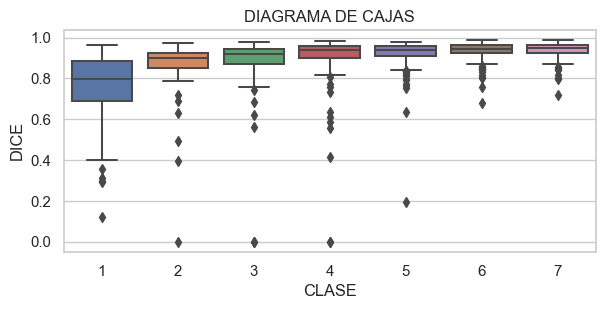

In [31]:
plt.figure(figsize=(7,3),dpi=98)
sns.set(style='whitegrid')
sns.boxplot(x="CLASE",y="DICE",data=datos2)
plt.title('DIAGRAMA DE CAJAS')

Citoplasma

Text(0.5, 1.0, 'DIAGRAMA DE CAJAS')

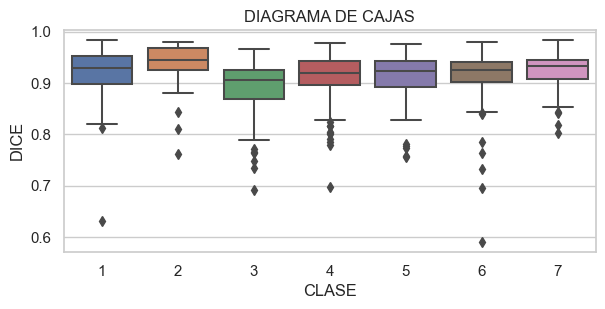

In [32]:
plt.figure(figsize=(7,3),dpi=98)
sns.set(style='whitegrid')
sns.boxplot(x="CLASE",y="DICE",data=datos1)
plt.title('DIAGRAMA DE CAJAS')

# CLASIFICACIÓN DE IMÁGENES

# Clasificación Binaria (BIN)

In [72]:
# Datos Balanceados
caractNucleo = pd.read_csv('Arhivos CSV/caractNucleoUnetBinBal2.csv',sep=';',index_col=0)
caractCito = pd.read_csv('Arhivos CSV/caractCitoUnetBinBal2.csv',sep=';',index_col=0)

Etiquetado para características del núcleo

In [73]:
for i,e in enumerate(caractNucleo.columns):
    nombre = 'n'+e
    caractNucleo.rename(columns={e:nombre},inplace=True)
    
caract = pd.DataFrame()
caract = pd.concat([caractNucleo,caractCito],axis=1)

caract['NC']= caractNucleo['nAREA']/caractCito['AREA']

caract.drop(columns=['nCLASE','nCELULA'],inplace=True)

Etiquetado de clases

In [74]:
# tres clases, citología
#normal, lsil,hsil
cytology = []
for ind, ele in enumerate(caract['CLASE']):
    if ele == 1 or ele == 2 or ele == 3:
        #1 NORMAL
         cytology.append(1)
    if ele == 4:
        #2 LSIL
        cytology.append(2)
    if ele == 5 or ele == 6 or ele == 7:
        #3 HSIL
        cytology.append(3)
caract['CYT'] = cytology


# cuatro  clases
#normal, CIN1,CIN2,CIN3
histology = []
for ind, ele in enumerate(caract['CLASE']):
    if ele == 1 or ele == 2 or ele == 3:
        #1 NORMAL
         histology.append(1)
    if ele == 4:
        #2 CIN1
        histology.append(2)
    if ele == 5:
        #3 CIN2
        histology.append(3)
    if ele == 6 or ele == 7:
        #4 CIN3
        histology.append(4)
caract['HIST'] = histology

# DOS CLASES
# dos clases, clasificacion binaria
#normal, lsil,hsil
binario = []
for ind, ele in enumerate(caract['CLASE']):
    if ele == 1 or ele == 2 or ele == 3:
         binario.append(1)
    if ele == 4 or ele == 5 or ele == 6 or ele == 7:
        binario.append(2)
caract['BIN'] = binario

Aumento de datos 

Text(0.5, 1.0, 'Cantidad de imágenes por clase')

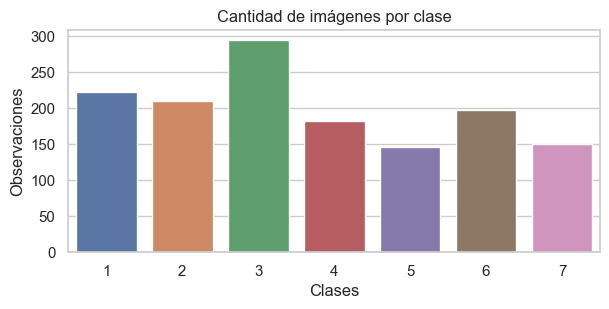

In [75]:
plt.figure(figsize=(7,3),dpi=98)
sns.countplot(x='CLASE',data=caract)
plt.xlabel('Clases')
plt.ylabel('Observaciones')
plt.title('Cantidad de imágenes por clase')

Text(0.5, 1.0, 'Cantidad de imágenes por clase')

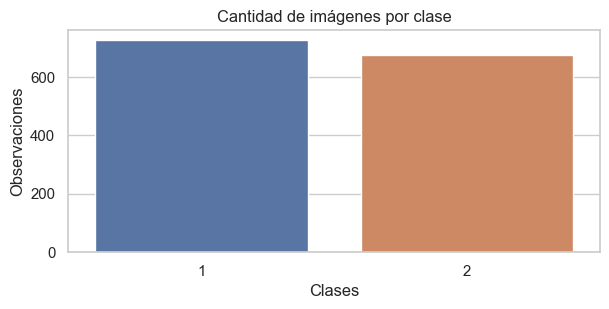

In [76]:
plt.figure(figsize=(7,3),dpi=98)
sns.countplot(x='BIN',data=caract)
plt.xlabel('Clases')
plt.ylabel('Observaciones')
plt.title('Cantidad de imágenes por clase')

Estandarización de las características

In [77]:
# CARACTERISTICAS A ESTANDARIZAR
matrizCaract = caract[caract.columns.drop(['BIN','HIST','CYT','CLASE','CELULA'])]
matrizCaract = pd.DataFrame(RobustScaler().fit_transform(matrizCaract),columns=caract.columns.drop(['BIN','HIST','CYT','CLASE','CELULA']))

matrizCaract['HERLEV'] = caract['CLASE']
matrizCaract['BIN'] = caract['BIN']
matrizCaract['CYT'] = caract['CYT']
matrizCaract['HIST'] = caract['HIST']

Matriz de Correlación Lineal 

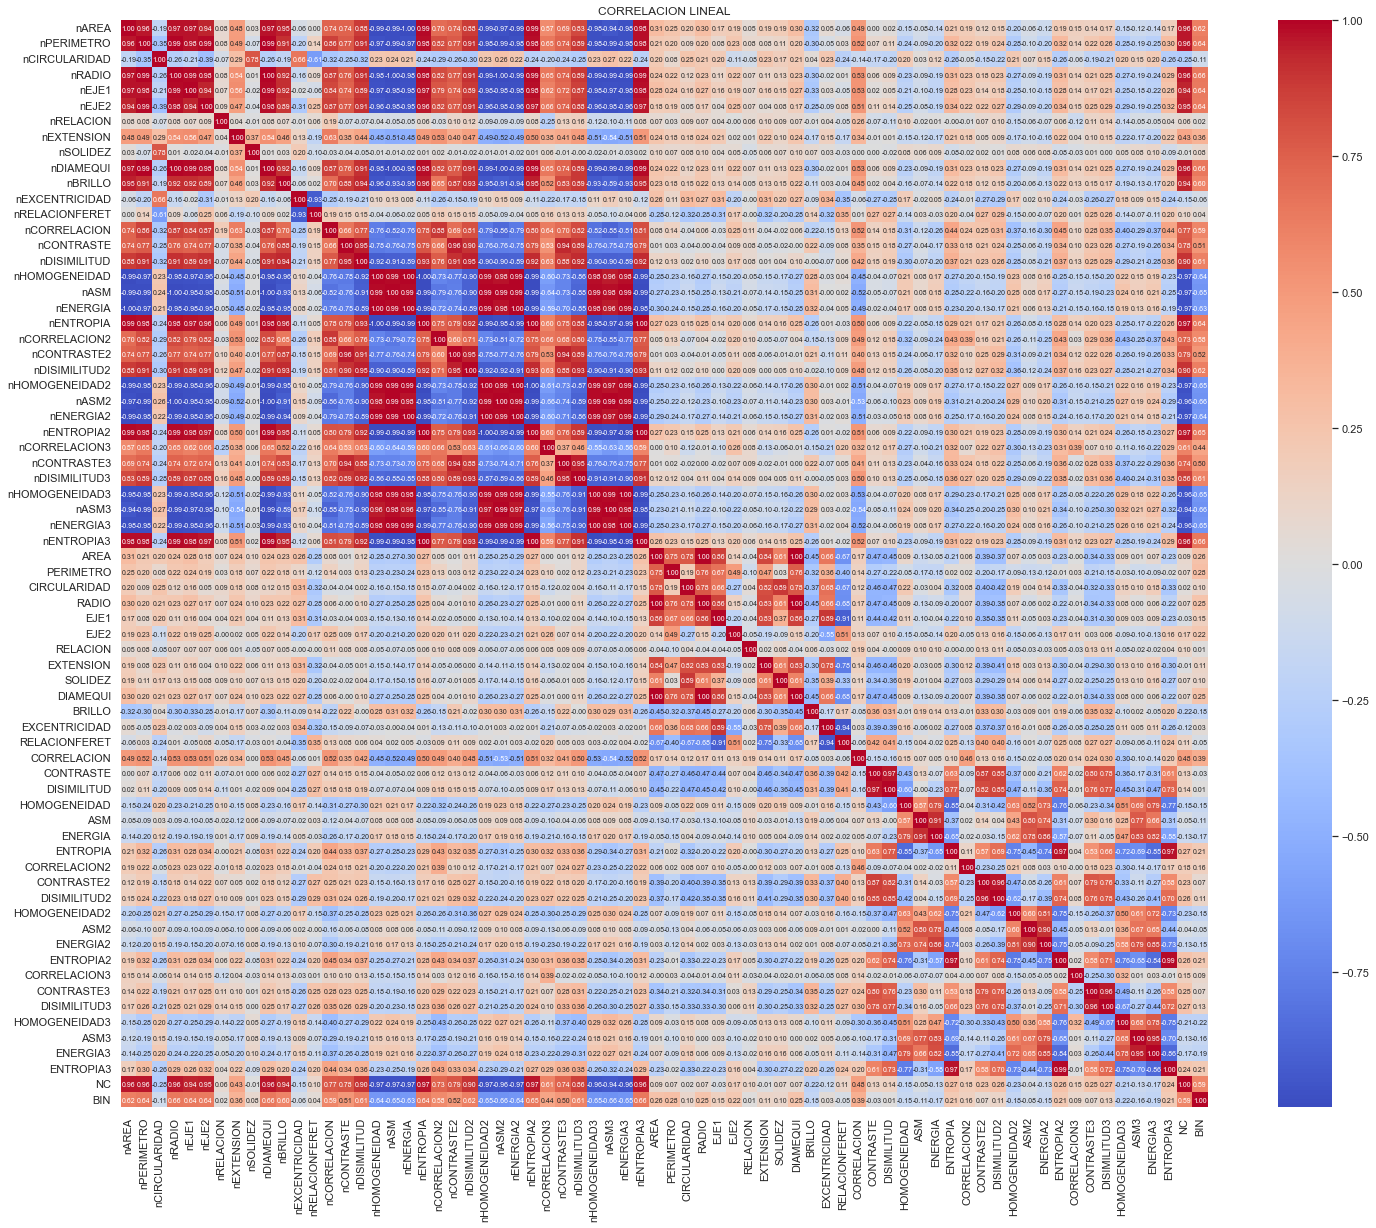

In [41]:
matrizCorrelacion = matrizCaract[matrizCaract.columns.drop(['HERLEV','CYT','HIST'])]
corr = matrizCorrelacion.corr()
plt.figure(figsize=(25,20))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 7},
           xticklabels= matrizCorrelacion.columns, 
           yticklabels= matrizCorrelacion.columns,
           cmap= 'coolwarm')
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)
plt.title('CORRELACION LINEAL')
plt.show()

SELECCIÓN DE CARACTERÍSTICAS

FEATUREWIZ

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.7 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Binary_Classification problem ####
    Loaded train data. Shape = (1401, 70)
#### Single_Label Binary_Classification problem ####
No test data filename given...
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
############################################

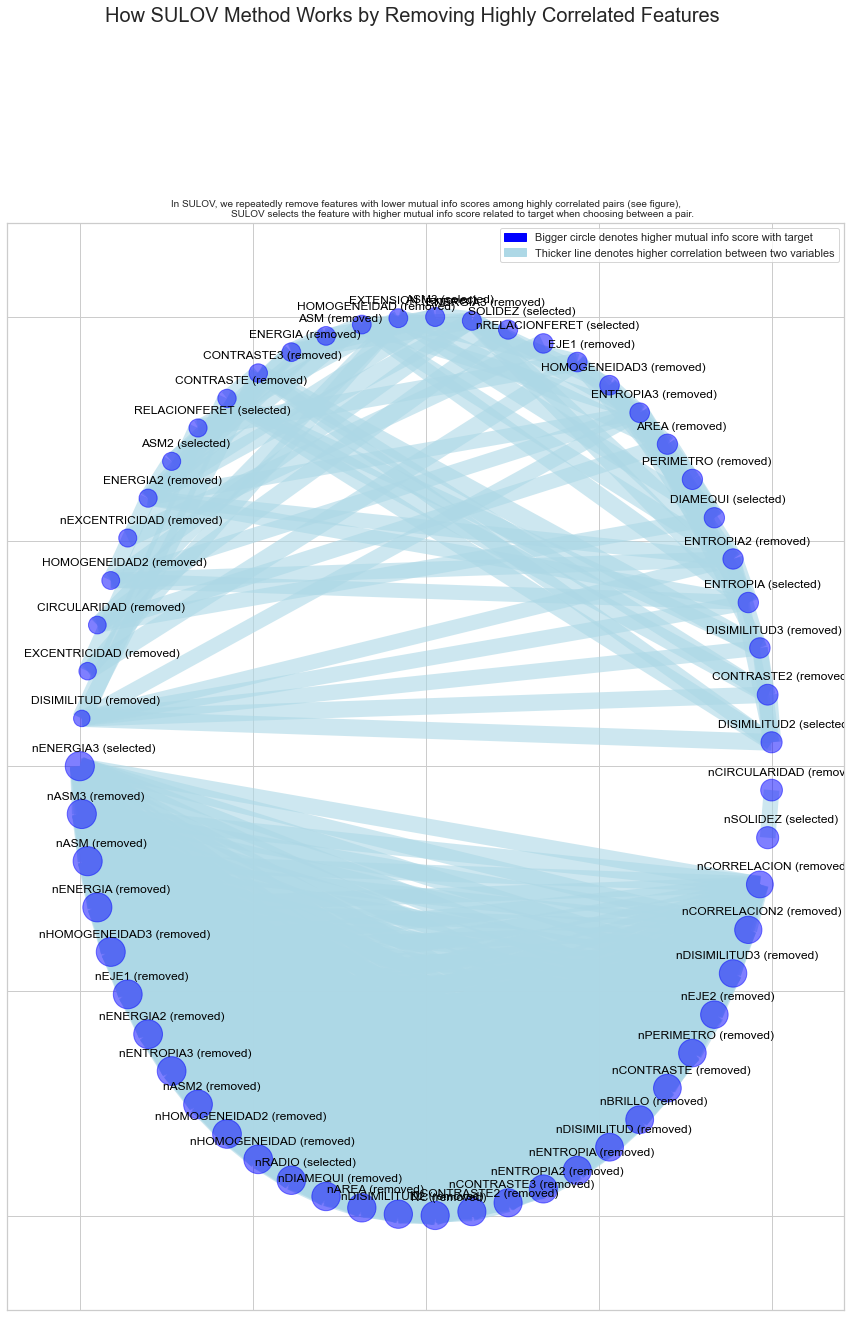

Time taken for SULOV method = 1 seconds
    Adding 0 categorical variables to reduced numeric variables  of 21
Final list of selected 21 vars after SULOV = ['BRILLO', 'CORRELACION', 'CORRELACION2', 'CORRELACION3', 'EJE2', 'RADIO', 'RELACION', 'nCORRELACION3', 'nEXTENSION', 'nRELACION', 'nENERGIA3', 'nRADIO', 'nSOLIDEZ', 'DISIMILITUD2', 'ENTROPIA', 'DIAMEQUI', 'nRELACIONFERET', 'SOLIDEZ', 'ASM3', 'RELACIONFERET', 'ASM2']
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Current number of predictors before recursive XGBoost = 21 
    Taking top 10 features per iteration...
    XGBoost version using 1.7.5 as tree method: hist
Number of booster rounds = 100
        using 21 variables...
Regu

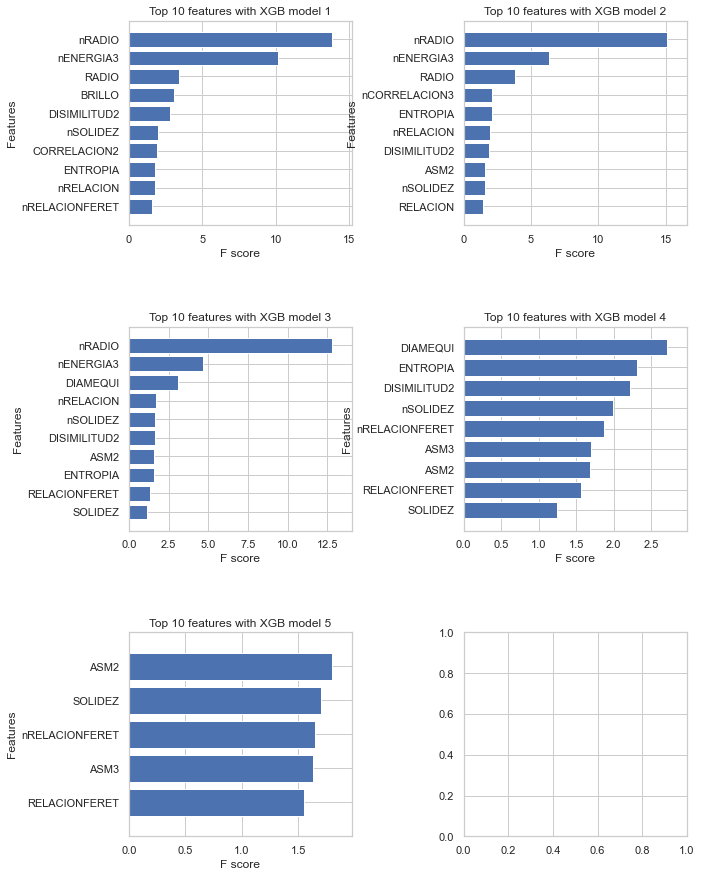

    Completed XGBoost feature selection in 1 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 13 important features:
['nRADIO', 'nENERGIA3', 'RADIO', 'BRILLO', 'DISIMILITUD2', 'nSOLIDEZ', 'CORRELACION2', 'ENTROPIA', 'nRELACION', 'nCORRELACION3', 'DIAMEQUI', 'ASM2', 'SOLIDEZ']
Total Time taken for featurewiz selection = 2 seconds
Output contains a list of 13 important features and a train dataframe


In [44]:
features = featurewiz(matrizCorrelacion, target='BIN', corr_limit=0.70, 
                                verbose=4)

PCA (Análisis de componentes principales)

las caracteristicas de FEATUREWIZ son combertidas al espacio PCA

In [47]:
#matriz = matrizCorrelacion[matrizCorrelacion.columns.drop(['BIN'])]
matriz= matrizCorrelacion[features[0]]

pca = PCA()
datos = pca.fit_transform(matriz)
#autovalores
print('variancia explicada por cada componente',pca.explained_variance_)
#proporcion
print('porporcion de la variancia explicada por cada componente',pca.explained_variance_ratio_)
print('suma de todas las proporiones',pca.explained_variance_ratio_.sum())

variancia explicada por cada componente [6.35232951e+00 3.77139396e+00 2.83061822e+00 9.83780764e-01
 9.56267653e-01 6.91088369e-01 5.90080983e-01 5.16107246e-01
 2.88364516e-01 1.10370048e-01 8.74301801e-02 9.53640838e-04
 4.06840167e-31]
porporcion de la variancia explicada por cada componente [3.69777576e-01 2.19537874e-01 1.64774063e-01 5.72671908e-02
 5.56656159e-02 4.02291760e-02 3.43494013e-02 3.00432914e-02
 1.67860832e-02 6.42478775e-03 5.08942743e-03 5.55127055e-05
 2.36827089e-32]
suma de todas las proporiones 0.9999999999999998


array([3.69777576e-01, 2.19537874e-01, 1.64774063e-01, 5.72671908e-02,
       5.56656159e-02, 4.02291760e-02, 3.43494013e-02, 3.00432914e-02,
       1.67860832e-02, 6.42478775e-03, 5.08942743e-03, 5.55127055e-05,
       2.36827089e-32])

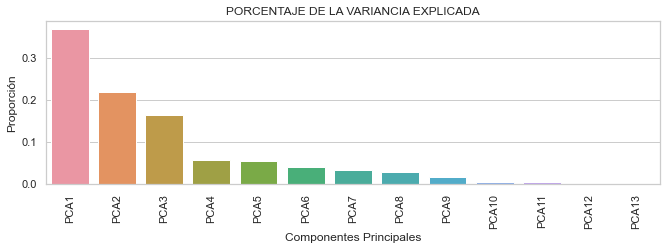

In [48]:
plt.figure(figsize=(11,3))
nomPCA = np.arange(len(pca.feature_names_in_))
nomPCA = ['PCA'+str(e+1)     for i,e in enumerate(nomPCA)]
sns.barplot(x=nomPCA,y= pca.explained_variance_ratio_)
plt.title('PORCENTAJE DE LA VARIANCIA EXPLICADA')
plt.xlabel('Componentes Principales')
plt.ylabel('Proporción')
plt.xticks(rotation = 90)
pca.explained_variance_ratio_

In [52]:
# Se añade la columna con las etiquetas de la clase BIN
dataPCA = pd.DataFrame(datos,columns=nomPCA)
dataPCA['BIN'] = matrizCorrelacion['BIN']

Espacio de Caracteristicas PCA y FEATUREWIZ 

* Generación de datos de entrenamiento (train) y de prueba (test).

In [58]:
dataPCA2 = dataPCA.values
X = dataPCA2[:,0:-2]
Y = dataPCA2[:,-1]
x_train,x_test,y_train,y_test= train_test_split(X,Y,test_size=0.2,random_state=0,stratify=Y)

Redes Neuronales ANN 

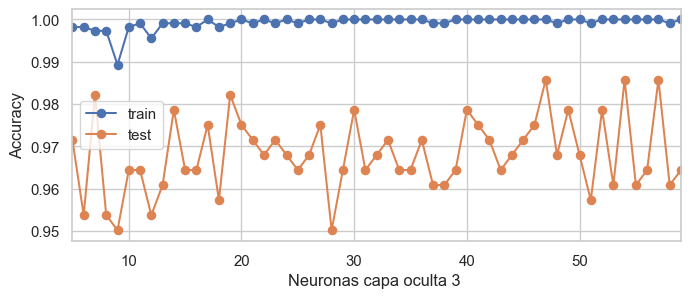

In [61]:
# optimizando hiperparámetros
aTest = []
aTrain = []
valor = np.arange(5,60,1)
for p in valor:
    red = MLPClassifier(random_state = 0,max_iter=100,hidden_layer_sizes=(100,80,p),activation='relu',solver='adam').fit(x_train,y_train)
    y_train_predict = red.predict(x_train);
    y_test_predict = red.predict(x_test);
    scoreTrain = accuracy_score(y_train_predict,y_train)
    scoreTest = accuracy_score(y_test_predict,y_test)
    aTest.append(scoreTest)
    aTrain.append(scoreTrain)
    #print('PROF:',p ,'SCORETEST: ',scoreTest,'     SCORETRAIN: ',scoreTrain)

plt.figure(figsize=(7,3),dpi=98)
plt.plot(valor,aTrain,'-o',label='train')
plt.plot(valor,aTest,'-o',label='test')
plt.tight_layout()
#plt.ylim(0.5,1)
plt.xlim(min(valor),max(valor))
plt.xlabel('Neuronas capa oculta 3 ')
plt.ylabel('Accuracy')
plt.legend()

Validación cruzada con datos de entrenamiento para evitar sesgos y evaluar el hiperparametro 

In [62]:
red = MLPClassifier(random_state = 0,max_iter=100,hidden_layer_sizes=(100,80,54),activation='relu',solver='adam')
scores = cross_val_score(red,x_train,y_train,cv=5,scoring='accuracy')
print('RESULTADOS')
print('puntaje por iteracion: ',scores, ' media:',scores.mean())

RESULTADOS
puntaje por iteracion:  [0.96428571 0.9375     0.94196429 0.91517857 0.91964286]  media: 0.9357142857142856


Modelo de clasificación BIN para imágenes de prueba 

porcentaje de aciertos sobre datos de entrenamiento 1.0
porcentaje de aciertos sobre datos de test 0.9857651245551602
------------------------------------------------
EVALUACION SOBRE DATOS DE TEST
accuracy: 0.9857651245551602  precision: 0.9733333333333334  recall: 1.0  f1: 0.9864864864864865
------------------------------------------------
INFORME DE CLASIFICACION
              precision    recall  f1-score   support

      clase1       0.97      1.00      0.99       146
      clase2       1.00      0.97      0.98       135

    accuracy                           0.99       281
   macro avg       0.99      0.99      0.99       281
weighted avg       0.99      0.99      0.99       281



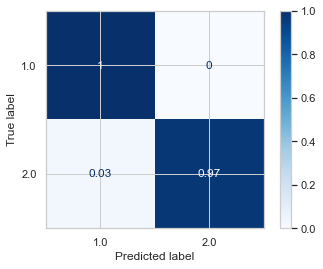

In [65]:
red = MLPClassifier(random_state = 0,max_iter=100,hidden_layer_sizes=(100,80,54),activation='relu',solver='adam').fit(x_train,y_train)

y_train_predict = red.predict(x_train)
y_test_predict = red.predict(x_test)
y_test_predict_prob = red.predict_proba(x_test)
print('porcentaje de aciertos sobre datos de entrenamiento',accuracy_score(y_train_predict,y_train))
print('porcentaje de aciertos sobre datos de test',accuracy_score(y_test_predict,y_test))
cm = confusion_matrix(y_true=y_test,y_pred=y_test_predict,normalize='true')
matriz  = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=red.classes_)
matriz.plot(cmap='Blues')

print('------------------------------------------------')
accuracy = accuracy_score(y_test,y_test_predict)
precision = precision_score(y_test,y_test_predict)
recall = recall_score(y_test,y_test_predict)                            
f1 = f1_score(y_test,y_test_predict)
print('EVALUACION SOBRE DATOS DE TEST')
print('accuracy:',accuracy,' precision:',precision,' recall:',recall,' f1:',f1)

# informe de clasificacion
print('------------------------------------------------')
target_names = ['clase1','clase2']
print('INFORME DE CLASIFICACION')
print(classification_report(y_test, y_test_predict, target_names=target_names))

Curva AUC-ROC

Area bajo la curva ROC:  0.9921867072552003


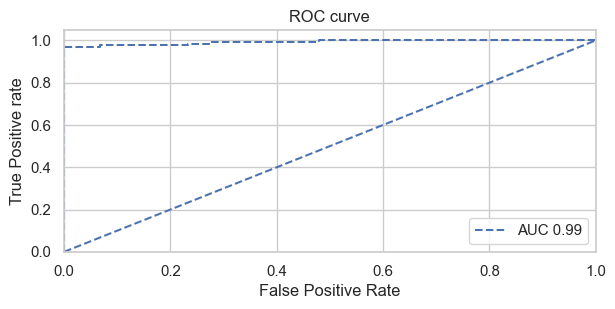

In [66]:
print('Area bajo la curva ROC: ', roc_auc_score(y_true=y_test,y_score=y_test_predict_prob[:,1]))
tfp, tvp, umbral = roc_curve(y_test,y_test_predict_prob[:,1],pos_label=2)
roc_auc= auc(tfp, tvp)
#plotting  
plt.figure(figsize=(7,3),dpi=98) 
plt.plot(tfp, tvp, linestyle='--',label='AUC '+str(np.round(roc_auc,2)))
plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()

# Clasificación de Tres Clases (CYT) 
corriente citológica (Normal, LSIL, HSIL)

In [78]:
#Datos Balanceados
caractNucleo = pd.read_csv('Arhivos CSV/caractNucleoUnetCytBal2.csv',sep=';',index_col=0)
caractCito = pd.read_csv('Arhivos CSV/caractCitoUnetCytBal2.csv',sep=';',index_col=0)

Etiquetado para características del núcleo

In [79]:

for i,e in enumerate(caractNucleo.columns):
    nombre = 'n'+e
    caractNucleo.rename(columns={e:nombre},inplace=True)
caract = pd.DataFrame()
caract = pd.concat([caractNucleo,caractCito],axis=1)

caract['NC']= caractNucleo['nAREA']/caractCito['AREA']

caract.drop(columns=['nCLASE','nCELULA'],inplace=True)

Etiquetado de clases

In [83]:
# tres clases, citología
#normal, lsil,hsil
cytology = []
for ind, ele in enumerate(caract['CLASE']):
    if ele == 1 or ele == 2 or ele == 3:
        #1 NORMAL
         cytology.append(1)
    if ele == 4:
        #2 LSIL
        cytology.append(2)
    if ele == 5 or ele == 6 or ele == 7:
        #3 HSIL
        cytology.append(3)
caract['CYT'] = cytology


# cuatro  clases
#normal, CIN1,CIN2,CIN3
histology = []
for ind, ele in enumerate(caract['CLASE']):
    if ele == 1 or ele == 2 or ele == 3:
        #1 NORMAL
         histology.append(1)
    if ele == 4:
        #2 CIN1
        histology.append(2)
    if ele == 5:
        #3 CIN2
        histology.append(3)
    if ele == 6 or ele == 7:
        #4 CIN3
        histology.append(4)
caract['HIST'] = histology

# DOS CLASES
# dos clases, clasificacion binaria
#normal, lsil,hsil
binario = []
for ind, ele in enumerate(caract['CLASE']):
    if ele == 1 or ele == 2 or ele == 3:
         binario.append(1)
    if ele == 4 or ele == 5 or ele == 6 or ele == 7:
        binario.append(2)
caract['BIN'] = binario

Aumento de datos

Text(0.5, 1.0, 'Cantidad de imágenes por clase')

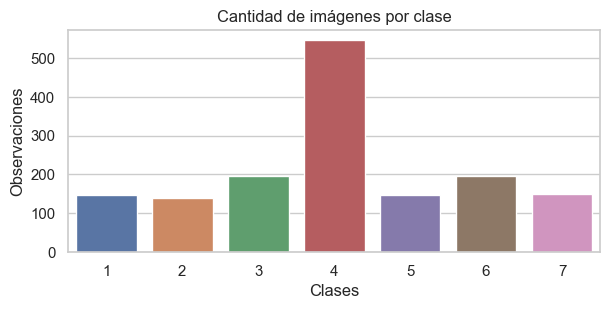

In [82]:
plt.figure(figsize=(7,3),dpi=98)
sns.countplot(x='CLASE',data=caract)
plt.xlabel('Clases')
plt.ylabel('Observaciones')
plt.title('Cantidad de imágenes por clase')

Text(0.5, 1.0, 'Cantidad de imágenes por clase')

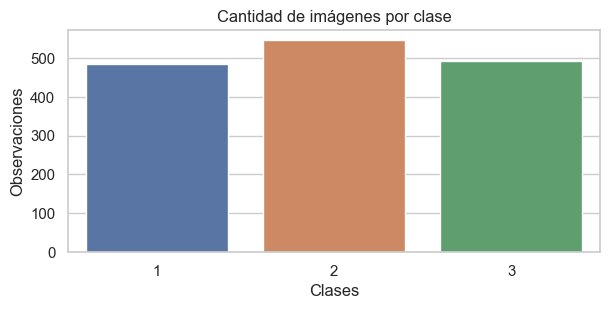

In [84]:
plt.figure(figsize=(7,3),dpi=98)
sns.countplot(x='CYT',data=caract)
plt.xlabel('Clases')
plt.ylabel('Observaciones')
plt.title('Cantidad de imágenes por clase')

Estandarización de las características

In [85]:
# CARACTERISTICAS A ESTANDARIZAR
matrizCaract = caract[caract.columns.drop(['BIN','HIST','CYT','CLASE','CELULA'])]
matrizCaract = pd.DataFrame(RobustScaler().fit_transform(matrizCaract),columns=caract.columns.drop(['BIN','HIST','CYT','CLASE','CELULA']))

matrizCaract['HERLEV'] = caract['CLASE']
matrizCaract['BIN'] = caract['BIN']
matrizCaract['CYT'] = caract['CYT']
matrizCaract['HIST'] = caract['HIST']

Matriz de correlación lineal

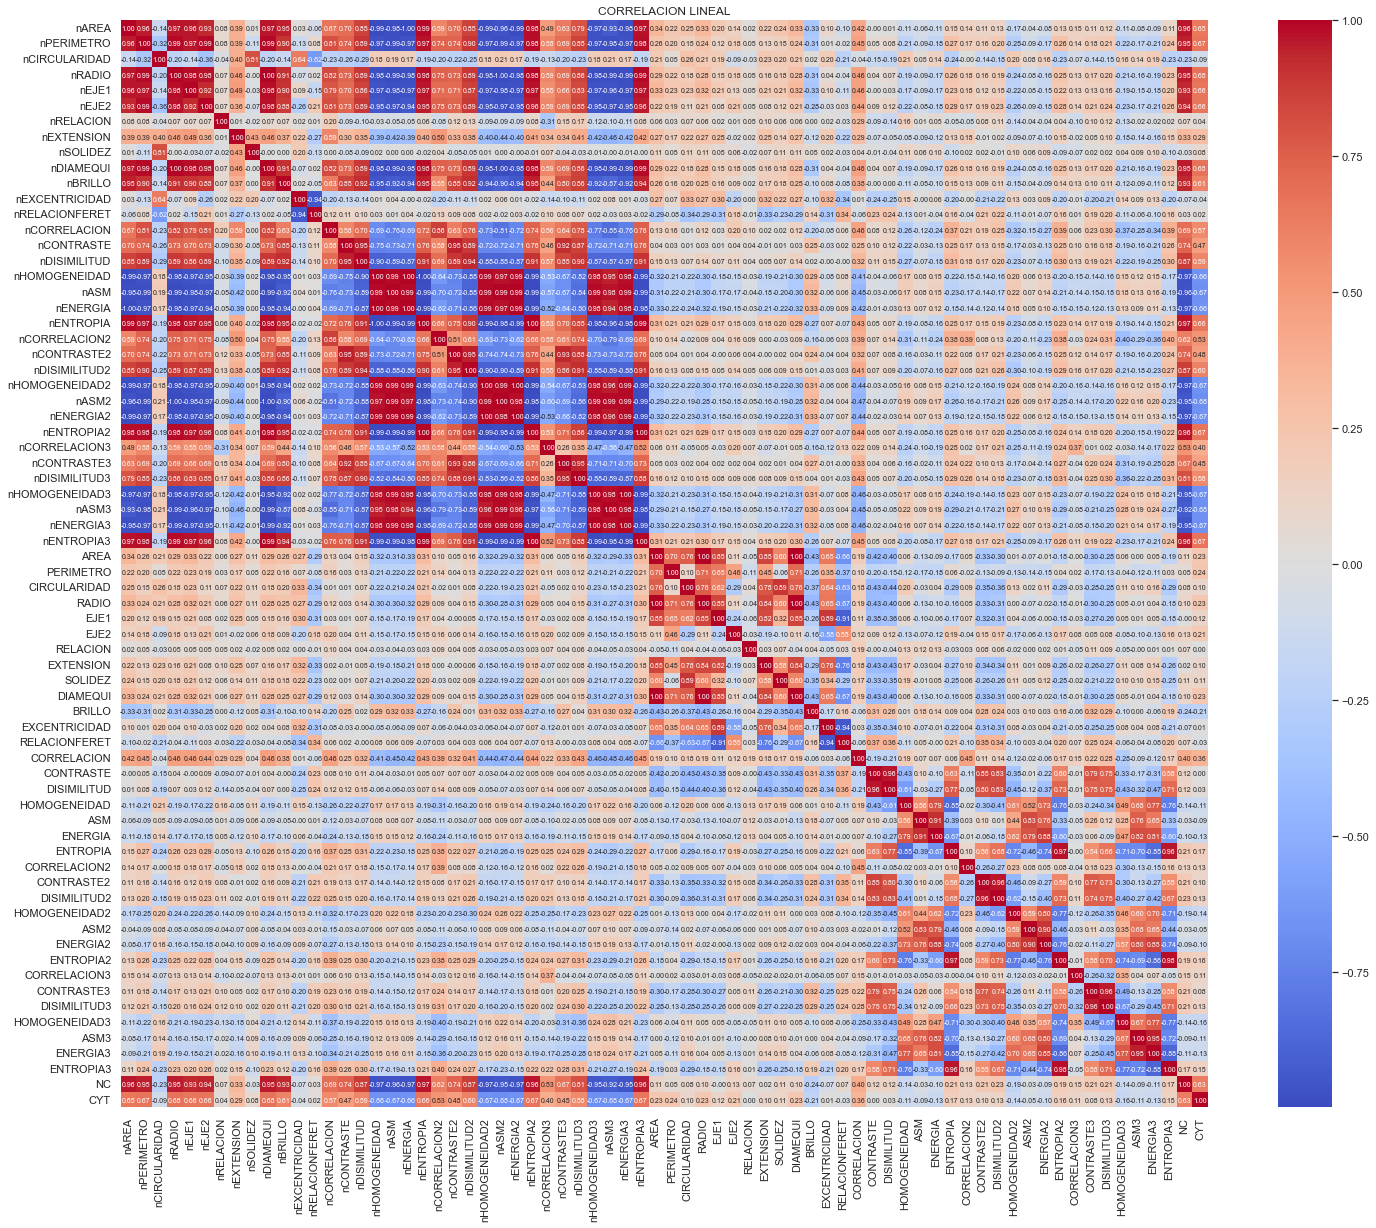

In [86]:
matrizCorrelacion = matrizCaract[matrizCaract.columns.drop(['HERLEV','BIN','HIST'])]
corr = matrizCorrelacion.corr()
plt.figure(figsize=(25,20))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 7},
           xticklabels= matrizCorrelacion.columns, 
           yticklabels= matrizCorrelacion.columns,
           cmap= 'coolwarm')
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)
plt.title('CORRELACION LINEAL')
plt.show()

SELECCIÓN DE CARACTERISTICAS

FEATUREWIZ

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.7 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Multi_Classification problem ####
    Loaded train data. Shape = (1523, 70)
#### Single_Label Multi_Classification problem ####
No test data filename given...
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
##############################################

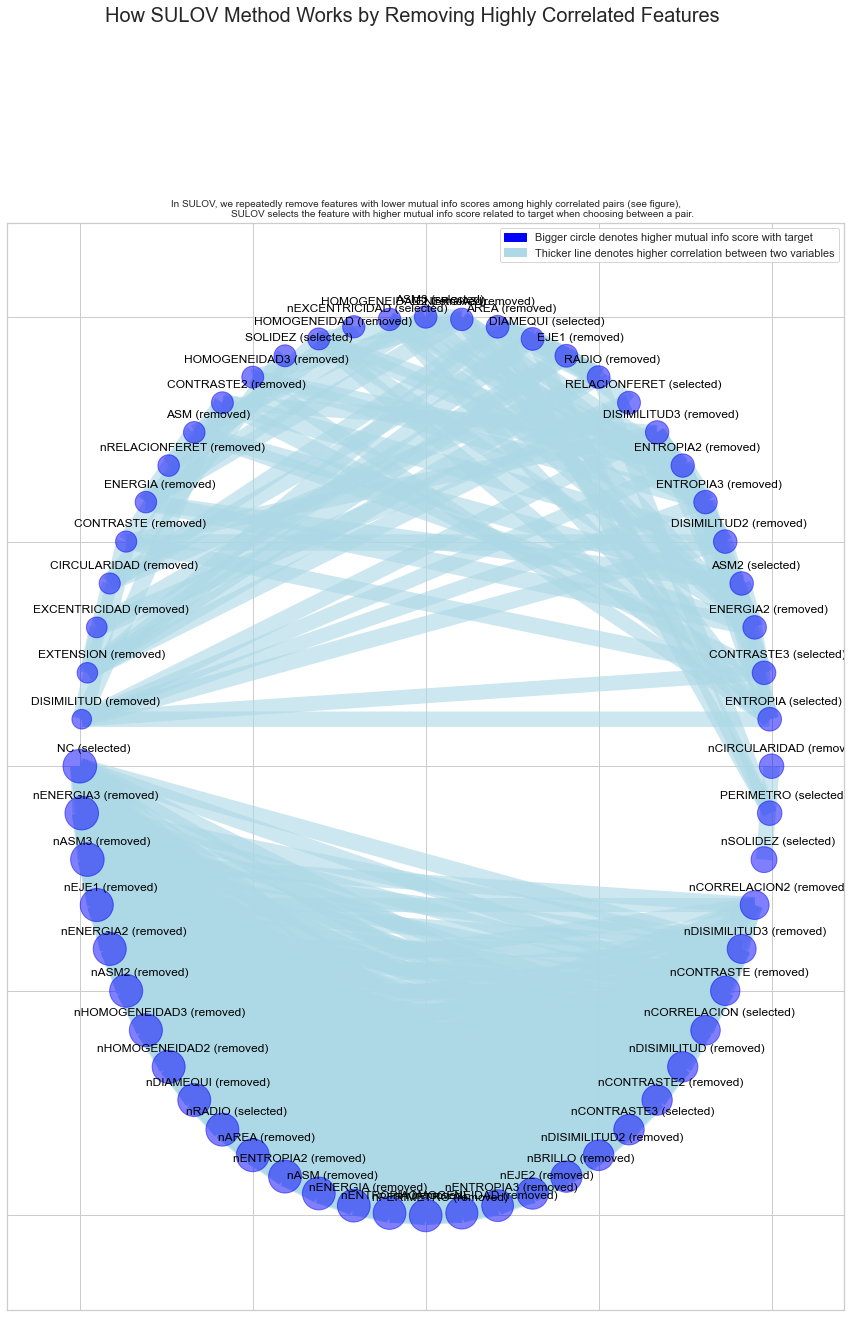

Time taken for SULOV method = 1 seconds
    Adding 0 categorical variables to reduced numeric variables  of 23
Final list of selected 23 vars after SULOV = ['BRILLO', 'CORRELACION', 'CORRELACION2', 'CORRELACION3', 'EJE2', 'RELACION', 'nCORRELACION3', 'nEXTENSION', 'nRELACION', 'NC', 'nRADIO', 'nCONTRASTE3', 'nCORRELACION', 'nSOLIDEZ', 'PERIMETRO', 'ENTROPIA', 'CONTRASTE3', 'ASM2', 'RELACIONFERET', 'DIAMEQUI', 'ASM3', 'nEXCENTRICIDAD', 'SOLIDEZ']
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Current number of predictors before recursive XGBoost = 23 
    Taking top 10 features per iteration...
    XGBoost version using 1.7.5 as tree method: hist
Number of booster rounds = 100
        

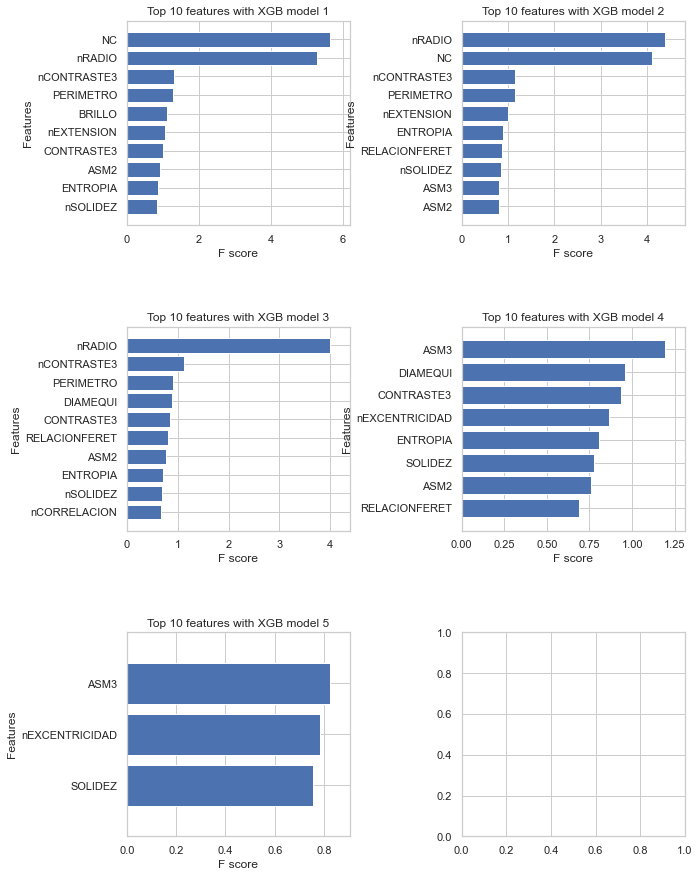

    Completed XGBoost feature selection in 1 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 8 important features:
['NC', 'nRADIO', 'nCONTRASTE3', 'PERIMETRO', 'BRILLO', 'nEXTENSION', 'CONTRASTE3', 'ASM3']
Total Time taken for featurewiz selection = 4 seconds
Output contains a list of 8 important features and a train dataframe


In [87]:
features = featurewiz(matrizCorrelacion, target='CYT', corr_limit=0.70, 
                                verbose=4)

Espacio de características FEATUREWIZ

* Generación de datos de entrenamiento (train) y de prueba (test).

In [88]:
feat = features[0].copy()
feat.append('CYT')
matrizCorrelacion2 = matrizCorrelacion[feat].values
X = matrizCorrelacion2[:,0:-2]
Y = matrizCorrelacion2[:,-1]

x_train,x_test,y_train,y_test= train_test_split(X,Y,test_size=0.2,random_state=0,stratify=Y)

k-vecinos  KNN 

Text(29.75, 0.5, 'Accuracy')

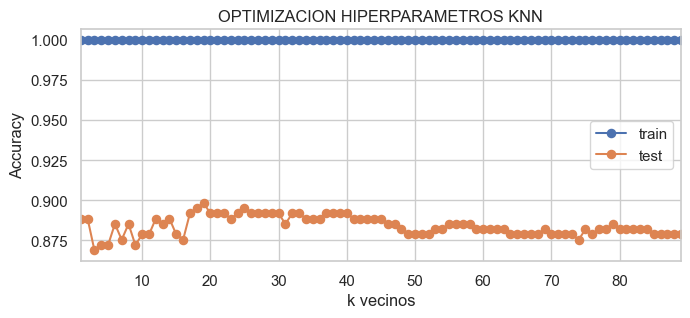

In [90]:
# optimizando hiperparámetros
aTest = []
aTrain = []
valor = np.arange(1,90,1)
for p in valor:
    knn = KNeighborsClassifier(n_neighbors=p,weights='distance').fit(x_train,y_train)
    y_train_predict = knn.predict(x_train)
    y_test_predict = knn.predict(x_test)
    scoreTrain = accuracy_score(y_train_predict,y_train)
    scoreTest = accuracy_score(y_test_predict,y_test)
    aTest.append(scoreTest)
    aTrain.append(scoreTrain)
    #print('PROF:',p ,'SCORETEST: ',scoreTest,'     SCORETRAIN: ',scoreTrain)
plt.figure(figsize=(7,3),dpi=98)
plt.plot(valor,aTrain,'-o',label='train')
plt.plot(valor,aTest,'-o',label='test')
plt.tight_layout()
plt.legend()
#plt.ylim(0,1)
plt.xlim(min(valor),max(valor))
plt.title('OPTIMIZACION HIPERPARAMETROS KNN')
plt.xlabel('k vecinos')
plt.ylabel('Accuracy')

Validación cruzada con datos de entrenamiento para evitar sesgos y evaluar el hiperparametro 

In [91]:
knn = KNeighborsClassifier(n_neighbors=20,weights='distance')
scores = cross_val_score(knn,x_train,y_train,cv=5,scoring='accuracy')
print('RESULTADOS')
print('puntaje por iteracion: ',scores, ' media:',scores.mean())

RESULTADOS
puntaje por iteracion:  [0.82786885 0.86885246 0.88114754 0.84773663 0.83539095]  media: 0.8521992848950954


Modelo de clasificación CYT para imágenes de prueba 

porcentaje de aciertos sobre datos de entrenamiento 1.0
porcentaje de aciertos sobre datos de test 0.8918032786885246
------------------------------------------------
EVALUACION SOBRE DATOS DE TEST
accuracy: 0.8918032786885246  precision: 0.9060472227882599  recall: 0.8886111978895485  f1: 0.888376927691673
------------------------------------------------
INFORME DE CLASIFICACION
              precision    recall  f1-score   support

      clase1       0.96      0.96      0.96        97
      clase2       0.81      1.00      0.90       109
      clase3       0.95      0.71      0.81        99

    accuracy                           0.89       305
   macro avg       0.91      0.89      0.89       305
weighted avg       0.90      0.89      0.89       305



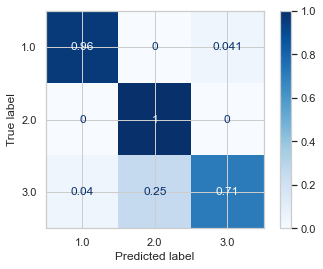

In [97]:
knn = KNeighborsClassifier(n_neighbors=20,weights='distance').fit(x_train,y_train)
y_train_predict = knn.predict(x_train)
y_test_predict = knn.predict(x_test)
y_test_predict_prob = knn.predict_proba(x_test)
print('porcentaje de aciertos sobre datos de entrenamiento',accuracy_score(y_train_predict,y_train))
print('porcentaje de aciertos sobre datos de test',accuracy_score(y_test_predict,y_test))
cm = confusion_matrix(y_true=y_test,y_pred=y_test_predict,normalize='true')
matriz  = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
matriz.plot(cmap='Blues')

print('------------------------------------------------')
accuracy = accuracy_score(y_test,y_test_predict,)
precision = precision_score(y_test,y_test_predict,average='macro')
recall = recall_score(y_test,y_test_predict,average='macro')                            
f1 = f1_score(y_test,y_test_predict,average='macro')
print('EVALUACION SOBRE DATOS DE TEST')
print('accuracy:',accuracy,' precision:',precision,' recall:',recall,' f1:',f1)

# informe de clasificacion
print('------------------------------------------------')
target_names = ['clase1','clase2','clase3']
print('INFORME DE CLASIFICACION')
print(classification_report(y_test, y_test_predict, target_names=target_names))

Curva AUC-ROC

Area bajo la curva ROC:  0.9938033455699355


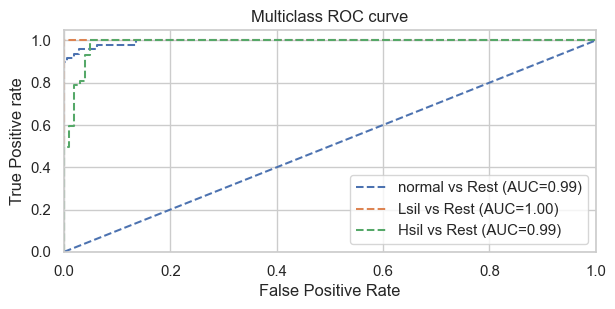

In [95]:
print('Area bajo la curva ROC: ', roc_auc_score(y_true=y_test,y_score=y_test_predict_prob,multi_class='ovr'))
# binarizacion de las clases del conjunto de test
#y_test_bin = label_binarize(y_test,classes=np.unique(y_test))
y_test_bin = label_binarize(y_test,classes=knn.classes_)
# curva ROC para las clases
tfp = {}
tvp = {}
umbral = {}
roc_auc = dict()
n_class = 3
#clases = ['clase1','clase2','clase3','clase4','clase5']
#clases = y_test.unique()
clases = knn.classes_
clases = ['normal','Lsil','Hsil']
plt.figure(figsize=(7,3),dpi=98) 
for i in range(n_class):    
    tfp[i], tvp[i], umbral[i] = roc_curve(y_test_bin[:,i],  y_test_predict_prob[:,i])
    roc_auc[i] = auc(tfp[i], tvp[i])
    
    # plotting    
    plt.plot(tfp[i], tvp[i], linestyle='--', 
             label='%s vs Rest (AUC=%0.2f)'%(clases[i],roc_auc[i]))

plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()